## Goal: get SNPs both CLOSE to SJs (exonic, +- 10 bp) and within SSs themselves

* 1. Use these to compute what % of novel SJs only in hap1/hap2 have a +- 10bp SNP OR SNP in the SS (should be very close to another I'm computing) AND
* 2. Subset on just known SJs to compute a known SJ-proximal SNP density score that I can use to correlate against the % increase in ICs / SJs detected to predict how much novel splicing we're missing in populations / samples that we actually didn't profile here
* Here, I want to get the indivdual set of info abotu % for each category (10bp OR ss)


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [38]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## We want to know what % of 1.5 NOVEL sjs that we 1. discover only in personal haplotypes that have snps +- 10 of splice junctions OR in splice sites

In [76]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

In [77]:
# 1.5 only novel sjs
temp = df.loc[df.junction_novelty=='novel']

In [78]:
# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

In [79]:
# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

In [80]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_12nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    df = df.drop_duplicates()
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    
    df['cell_line_id'] = c
    df['exon_12nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)
sj_snp_df.head()

,sj_id,cell_line_id,exon_12nt_has_var
0,chr1_+_100133316_100136881,HG04217,True
1,chr1_+_101371522_101389669,HG04217,True
2,chr1_+_101371524_101377257,HG04217,True
3,chr1_+_101371524_101383321,HG04217,True
4,chr1_+_101371524_101383417,HG04217,True


In [81]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'exon_12nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.exon_12nt_has_var.fillna(False, inplace=True)

In [82]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_10nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    df = df.drop_duplicates()
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    
    df['cell_line_id'] = c
    df['exon_10nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)
sj_snp_df.head()

,sj_id,cell_line_id,exon_10nt_has_var
0,chr1_+_100133316_100136881,HG04217,True
30,chr1_+_101371524_101377257,HG04217,True
55,chr1_+_101371524_101383321,HG04217,True
62,chr1_+_101371524_101383417,HG04217,True
87,chr1_+_101371524_101389669,HG04217,True


In [83]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'exon_10nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.exon_10nt_has_var.fillna(False, inplace=True)

In [84]:
# # infer if SS has var by just looking if the 12nt span has a variant 
# # and the 10nt (only exon) doesn't
# temp['ss_has_var'] = (temp['exon_12nt_has_var']==True)&(temp['exon_10nt_has_var']==False)
# this is problematic just need to get the 2 nt thing too

In [61]:
# # how many vars are we talking per cell line?
# temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# # compute % of SJs / cell_line_id that have ss vars
# temp['n_sj_ss_var'] = temp.groupby(['cell_line_id', 'ss_has_var'])['sj_id'].transform('nunique')
# temp['perc_sj_ss_var'] = (temp['n_sj_ss_var']/temp['n_sj'])*100

# # compute % of SJs / cell_line_id that have +-10bp exonic vars
# temp['n_sj_exon_var'] = temp.groupby(['cell_line_id', 'exon_10nt_has_var'])['sj_id'].transform('nunique')
# temp['perc_sj_exon_var'] = (temp['n_sj_exon_var']/temp['n_sj'])*100

# # get # sjs per exon / ss var + cell line status
# temp['n_sj_var_status'] = temp.groupby(['cell_line_id', 'exon_10nt_has_var',
#                                         'ss_has_var'])['sj_id'].transform('nunique')

In [86]:
# what detection categories do we even have? 
temp[['exon_10nt_has_var', 'ss_has_var']].drop_duplicates()

,exon_10nt_has_var,ss_has_var
0,False,False
4,True,False
13,False,True


In [62]:
# how many vars are we talking per cell line?
temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# for each combination of explanations, what % of sjs are explained?
# (and for each cell line)
temp['n_sj_w_explanation'] = temp.groupby(['cell_line_id', 'exon_10nt_has_var', 'ss_has_var'])['sj_id'].transform('nunique')
temp['perc_sj_w_explanation'] = (temp['n_sj_w_explanation']/temp['n_sj'])*100

In [63]:
temp.head()

,sj_id,cell_line_id,hap1,hap2,hg38,exon_12nt_has_var,exon_10nt_has_var,ss_has_var,n_sj,n_sj_w_explanation,perc_sj_w_explanation
0,GL000194.1_-_53893_55445,HG03729,False,True,False,False,False,False,575,325,56.521739
1,GL000194.1_-_53893_55445,HG04217,False,True,False,False,False,False,514,303,58.949416
2,GL000194.1_-_54956_55445,HG04217,False,True,False,False,False,False,514,303,58.949416
3,KI270726.1_+_26127_26229,HG02261,True,False,False,False,False,False,695,387,55.683453
4,chr10_+_100987611_100989643,NA19307,True,True,False,True,True,False,467,128,27.408994


In [64]:
keep_cols = ['exon_10nt_has_var', 'ss_has_var', 
              'n_sj', 'n_sj_w_explanation', 'perc_sj_w_explanation',
             'cell_line_id']
temp = temp[keep_cols]
print(len(temp.index))
temp = temp.drop_duplicates()
print(len(temp.index))

14628
90


In [67]:
temp['# SJs'] = temp.n_sj
temp['% SJs'] = temp.perc_sj_w_explanation

In [70]:
temp.rename({'exon_10nt_has_var': 'Exonic variant\n+-10bp from SJ', 
             'ss_has_var': 'SS variant'}, axis=1, inplace=True)

In [71]:
temp.set_index(['Exonic variant\n+-10bp from SJ', 'SS variant'], inplace=True)
temp.head()

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 325   
                               False        514                 303   
                               False        695                 387   
True                           False        467                 128   
                               False        577                 149   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   56.521739      HG03729   
                               False                   58.949416      HG04217   
                               False                   55.683453      HG02261   
True                           False                   27.408994      NA19307   
                               False                   25.823224      HG01952   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  56.521739  
                               False         514  58.949416  
                               False         695  55.683453  
True                           False         467  27.408994  
                               False         577  25.823224

In [75]:
temp

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 325   
                               False        514                 303   
                               False        695                 387   
True                           False        467                 128   
                               False        577                 149   
...                                         ...                 ...   
False                          False        467                 252   
                               True         403                  65   
                               True         510                  94   
                               True         336                  59   
                               True         447                  89   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   56.521739      HG03729   
                               False                   58.949416      HG04217   
                               False                   55.683453      HG02261   
True                           False                   27.408994      NA19307   
                               False                   25.823224      HG01952   
...                                                          ...          ...   
False                          False                   53.961456      NA19307   
                               True                    16.129032      HG03719   
                               True                    18.431373      NA19390   
                               True                    17.559524      NA12273   
                               True                    19.910515      NA19129   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  56.521739  
                               False         514  58.949416  
                               False         695  55.683453  
True                           False         467  27.408994  
                               False         577  25.823224  
...                                          ...        ...  
False                          False         467  53.961456  
                               True          403  16.129032  
                               True          510  18.431373  
                               True          336  17.559524  
                               True          447  19.910515  

[90 rows x 6 columns]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


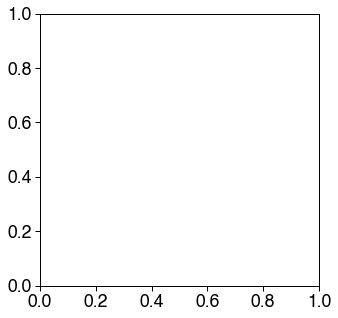

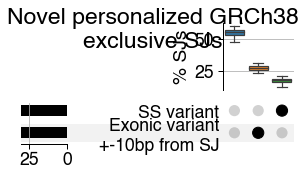

In [74]:
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='box',
    value='% SJs')
ax = plt.gca()
upset.plot()
plt.suptitle('Novel personalized GRCh38\nexclusive SJs')
plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)